# Install environment
### you'll need [anaconda](https://www.anaconda.com/download)
### see [ultralytics](https://docs.ultralytics.com/quickstart/)
```bash
conda create -n kibo python=3.11
conda activate kibo
# Install the ultralytics package from PyPI
pip install ultralytics
pip install matplotlib
```
### You'll need to install [pytorch](https://pytorch.org/get-started/locally/)
### for windows with nvdia gpu
```bash
conda install cudatooolkit=11.8
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
```
### other os or gpu... god bless you

### TODO: env in google colab

# Check installation of pytorch

In [1]:
import torch
import os

print(torch.__version__)
if os.name == 'nt':
    # windows
    print(f'cuda: {torch.cuda.is_available()}')
else:
    # mac
    print(f'mps: {torch.backends.mps.is_available()}')


2.2.2+cu118
cuda: True


# Prepare [dataset](https://docs.ultralytics.com/zh/datasets/) by randomly generate items
### sturcture of dataset
```batch
dataset/
├── train/
│   ├── images/
│   └── labels/
└── val/
    ├── images/
    └── labels/
```

### create dataset sturcture

In [1]:
import os

print(f'current dir: {os.getcwd()}')

# create dataset sturcture
base_dir = os.getcwd()
dataset = os.path.join(base_dir, 'datasets')
os.makedirs(dataset, exist_ok=True)
os.makedirs(os.path.join(dataset, "train"), exist_ok=True)
os.makedirs(os.path.join(dataset, "val"), exist_ok=True)
os.makedirs(os.path.join(dataset, "train", "images"), exist_ok=True)
os.makedirs(os.path.join(dataset, "train", "labels"), exist_ok=True)
os.makedirs(os.path.join(dataset, "val", "images"), exist_ok=True)
os.makedirs(os.path.join(dataset, "val", "labels"), exist_ok=True)

# print dataset structure
for root, dirs, files in os.walk(dataset):
    level = root.replace(dataset, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f'{subindent}{f}')

current dir: d:\Programming\JAVA\Kibo\kibo5th
datasets/
    train/
        images/
        labels/
    val/
        images/
        labels/


# create dataset
### config

train count: 80, val count: 20


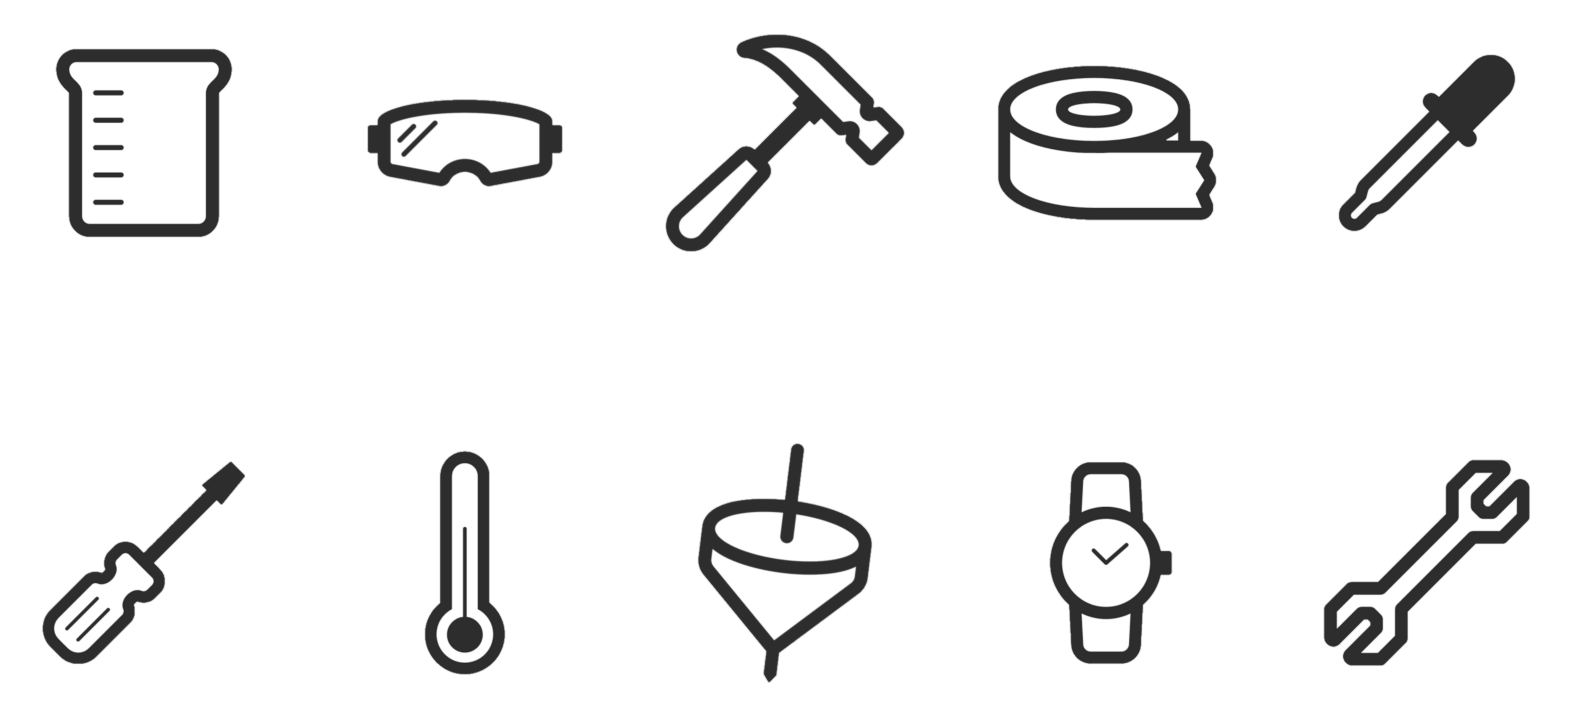

In [2]:
train_val_ratio = 0.8
data_count = 1e2

train_count = int(data_count * train_val_ratio)
val_count = int(data_count - train_count)
print(f'train count: {train_count}, val count: {val_count}')

width, height = 640, 480

# show images
from PIL import Image
import matplotlib.pyplot as plt

item_image_dir = "lost_item_images"
images = os.listdir(item_image_dir)
plt.subplots(2, 5, figsize=(20, 10))
for i, image in enumerate(images[:10]):
    img = Image.open(os.path.join(item_image_dir, image))
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')

In [3]:
# Assuming `images` is defined somewhere before this code snippet
item_names = sorted([name.split(".")[0] for name in images])
print(f"item names: {item_names}")

item_dict = {name: i for i, name in enumerate(item_names)}
for i, name in enumerate(item_names):
    print(f"\t{i}: {name}")

item names: ['beaker', 'goggle', 'hammer', 'kapton_tape', 'pipette', 'screwdriver', 'thermometer', 'top', 'watch', 'wrench']
	0: beaker
	1: goggle
	2: hammer
	3: kapton_tape
	4: pipette
	5: screwdriver
	6: thermometer
	7: top
	8: watch
	9: wrench


### generate

In [5]:
import random
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


def get_yolo_bbox(x1, y1, x2, y2, width, height):
    x_center = (x1 + x2) / (2 * width)
    y_center = (y1 + y2) / (2 * height)
    bbox_width = (x2 - x1) / width
    bbox_height = (y2 - y1) / height
    return x_center, y_center, bbox_width, bbox_height


def put_image(width, height, plane, item_image, x, y, angle, scale):
    item_height, item_width, channels = item_image.shape

    # Rotation matrix
    M = cv2.getRotationMatrix2D((item_width / 2, item_height / 2), angle, scale)
    rotated_corners = cv2.transform(
        np.array(
            [[[0, 0], [item_width, 0], [item_width, item_height], [0, item_height]]],
            dtype=np.float32,
        ),
        M,
    )[0]

    # Rotate image
    item_image_rotated = cv2.warpAffine(
        item_image, M, (item_width, item_height), borderValue=(255, 255, 255, 0)
    )

    x_min = int(min(rotated_corners[:, 0]))
    x_max = int(max(rotated_corners[:, 0]))
    y_min = int(min(rotated_corners[:, 1]))
    y_max = int(max(rotated_corners[:, 1]))

    # Cut the image
    item_image_rotated = item_image_rotated[y_min:y_max, x_min:x_max]

    x1 = x
    y1 = y
    x2 = x + item_image_rotated.shape[1]
    y2 = y + item_image_rotated.shape[0]

    if x1 < 0 or y1 < 0 or x2 > width or y2 > height:
        return False, None

    bbox = get_yolo_bbox(x1, y1, x2, y2, width, height)
    plane_slice = plane[y1:y2, x1:x2]

    # Alpha blending
    item_image_rotated_alpha = item_image_rotated[:, :, 3] / 255.0
    for c in range(3):
        plane_slice[:, :, c] = (
            plane_slice[:, :, c] * (1 - item_image_rotated_alpha)
            + item_image_rotated_alpha * item_image_rotated[:, :, c]
        )

    return True, bbox


def generate_image(item_image, item_count, height, width):
    plane = (
        np.ones((height, width, 4), dtype=np.uint8) * 255
    )  # Initialize plane with alpha channel
    count = 0
    bboxs = []
    while count < item_count:
        scale = random.uniform(0.2, 0.6)
        x, y = random.randint(0, width), random.randint(0, height)
        angle = random.randint(0, 360)
        success, bbox = put_image(width, height, plane, item_image, x, y, angle, scale)
        if success:
            count += 1
            bboxs.append(bbox)

    return plane, bboxs


def generate_images(item_images, item_dict, save_dir, height, width, count):
    for i in range(count):
        choice = random.choice(item_images)
        item_image = cv2.imread(
            os.path.join(item_image_dir, choice), cv2.IMREAD_UNCHANGED
        )
        item_count = random.randint(1, 5)
        plane, bboxs = generate_image(item_image, item_count, height, width)
        image_path = os.path.join(save_dir, "images", f"{i}.png")
        label_path = os.path.join(save_dir, "labels", f"{i}.txt")
        cv2.imwrite(image_path, plane)
        with open(label_path, "w") as f:
            for bbox in bboxs:
                class_id = item_dict[choice.split(".")[0]]
                f.write(f"{class_id} ")
                f.write(" ".join(map(str, bbox)) + "\n")


generate_images(
    images, item_dict, os.path.join(dataset, "train"), height, width, train_count
)
generate_images(
    images, item_dict, os.path.join(dataset, "val"), height, width, val_count
)

# view bboxs

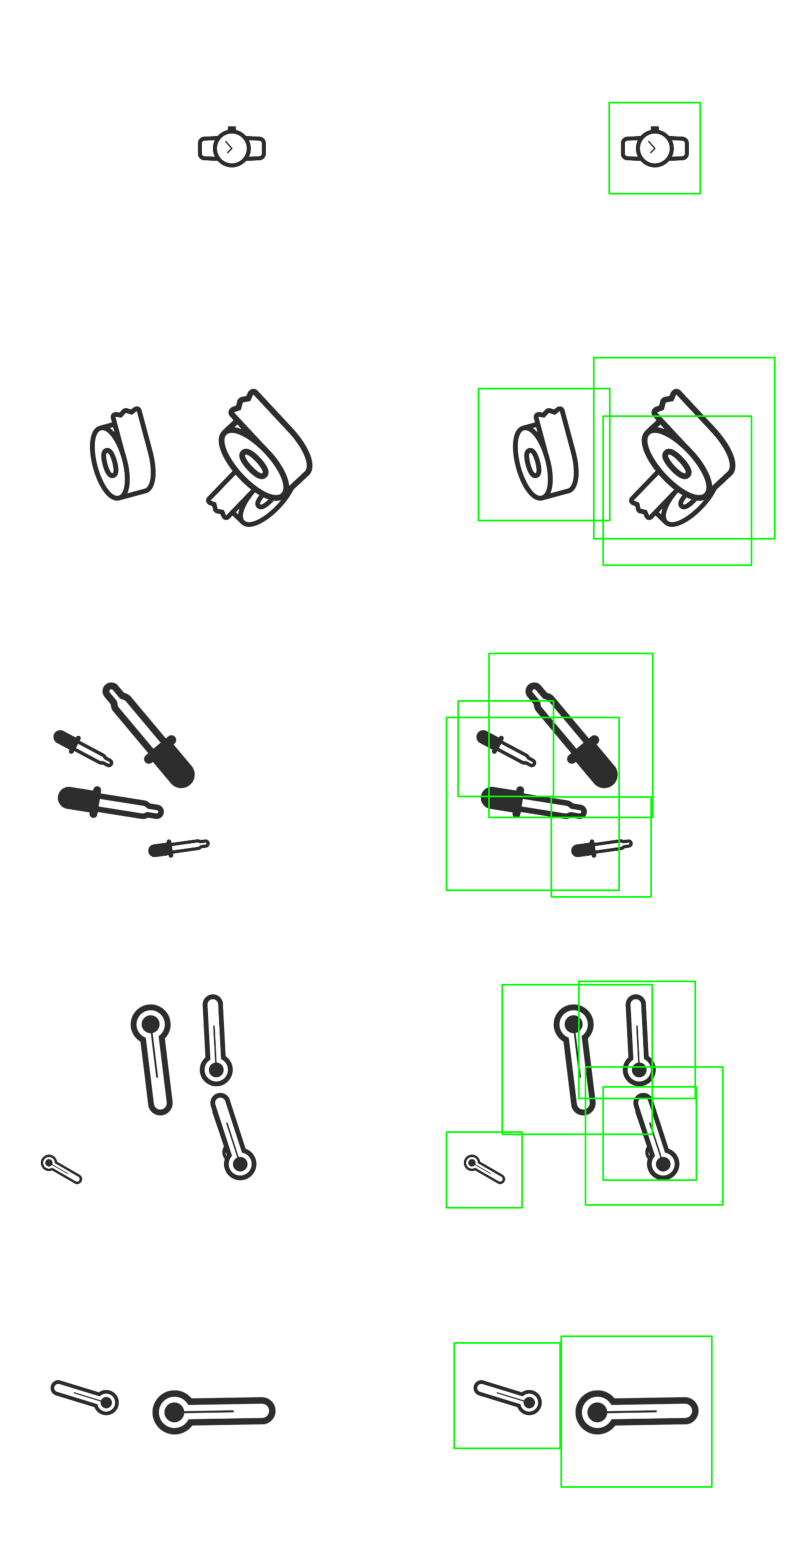

In [8]:
import os
import cv2
import matplotlib.pyplot as plt


def draw_bbox(image, bboxs, width=640, height=480):
    for bbox in bboxs:
        x_center, y_center, bbox_width, bbox_height = bbox
        x1 = int((x_center - bbox_width / 2) * width)
        y1 = int((y_center - bbox_height / 2) * height)
        x2 = int((x_center + bbox_width / 2) * width)
        y2 = int((y_center + bbox_height / 2) * height)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return image

data_dir = "datasets/train"
images = sorted(os.listdir(os.path.join(data_dir, "images")))
labels = sorted(os.listdir(os.path.join(data_dir, "labels")))
plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    image = cv2.imread(os.path.join(data_dir, "images", images[i]))
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    with open(os.path.join(data_dir, "labels", labels[i])) as f:
        bboxs = [list(map(float, line.strip().split()[1:])) for line in f]
    image_with_bbox = draw_bbox(image, bboxs)
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
    plt.axis("off")

# For more detail see [yolo doc](https://docs.ultralytics.com/quickstart/#install-ultralytics)

In [2]:
from ultralytics import YOLO


# Load a pretrained YOLO model (recommended for training)
model = YOLO("best.pt")

# results = model.train(data="kibo.yaml", epochs=1)

# results = model.val()

# Export the model to ONNX format
success = model.export(format="onnx", opset=10)

Ultralytics YOLOv8.1.42  Python-3.11.8 torch-2.2.2+cu118 CPU (11th Gen Intel Core(TM) i7-11800H 2.30GHz)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (6.0 MB)

ONNX: starting export with onnx 1.16.0 opset 10...
ONNX: export success  0.6s, saved as 'best.onnx' (11.7 MB)

Export complete (2.5s)
Results saved to D:\Programming\JAVA\Kibo\kibo5th
Predict:         yolo predict task=detect model=best.onnx imgsz=640  
Validate:        yolo val task=detect model=best.onnx imgsz=640 data=/content/gdrive/MyDrive/kibo.yaml  
Visualize:       https://netron.app


In [ ]:
results = model.val()